
# Galaxy vs. quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey.

SDSS observed in four bands:
<center>
    <img src="https://github.com/Alice-Palladino/astrostatistics_bicocca_2024/blob/main/working/quasars.png?raw=true" alt="SDSS observations" width="500">
</center>

### Data

The dataset is at solutions/galaxyquasar.csv. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used SQL and want to learn something new it's computing, it's very powerful)

### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy $=0$ and quasar $=1$.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

### Ideas

- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from astroML.classification import GMMBayes
from sklearn.model_selection import KFold

from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import random
from IPython.display import display, Markdown

np.random.seed(336)
random.seed(336)

In [100]:
data = pd.read_csv('galaxyquasar.csv')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
usecols = ['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']

u_g = np.array(data.get(usecols[0]) - data.get(usecols[1]))
g_r = np.array(data.get(usecols[1]) - data.get(usecols[2]))
r_i = np.array(data.get(usecols[2]) - data.get(usecols[3]))
i_z = np.array(data.get(usecols[3]) - data.get(usecols[4]))

target = np.array(data.get(usecols[5]))
y = np.empty(shape = u_g.size)     # Class labels

for i, label in enumerate(target):
    if (label == 'GALAXY'): y[i] = 0
    elif (label == 'QSO'): y[i] = 1

We can first explore how, for each color, the quasar and galaxy data are distributed:

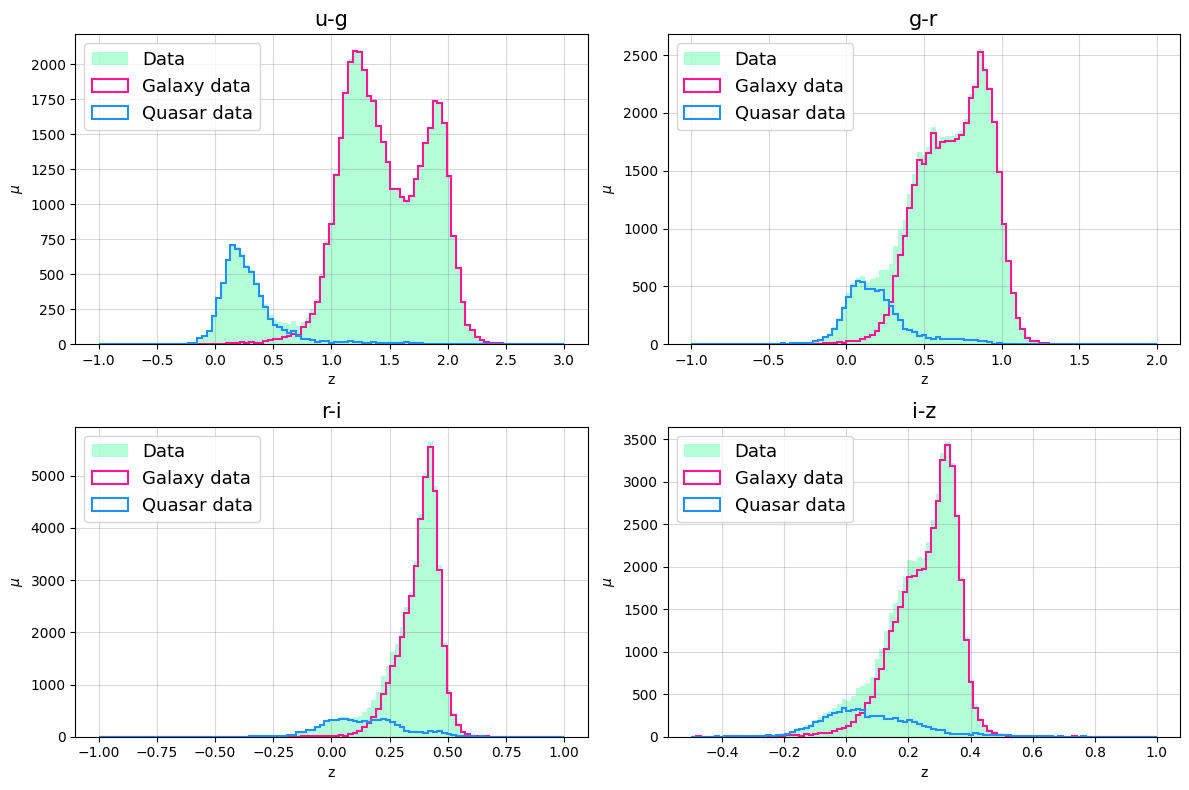

In [5]:
data_array = [u_g, g_r, r_i, i_z]
titles = ['u-g', 'g-r', 'r-i', 'i-z']
bins = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]

fig = plt.figure(figsize=(12, 8))
axes = []

for i, col in enumerate(data_array):
    ax = fig.add_subplot(2,2,1+i)
    axes.append(ax)
    plt.hist(col, bins = bins[i], color = 'springgreen', alpha = 0.3, label = 'Data')
    plt.hist(col[y==0], bins = bins[i], histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    plt.hist(col[y==1], bins = bins[i], histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    ax.grid(c='grey', alpha = 0.2)
    ax.set_xlabel('z')
    ax.set_ylabel('$\\mu$')
    ax.set_title(titles[i], fontsize = 15)
    ax.grid(alpha=0.3, c='gray')
    ax.legend(loc='upper left', fontsize = 13)

plt.tight_layout()
plt.show()

For the $(u-g)$ data, the distributions are clearly separated; this is not so noticeable for the other colors. 

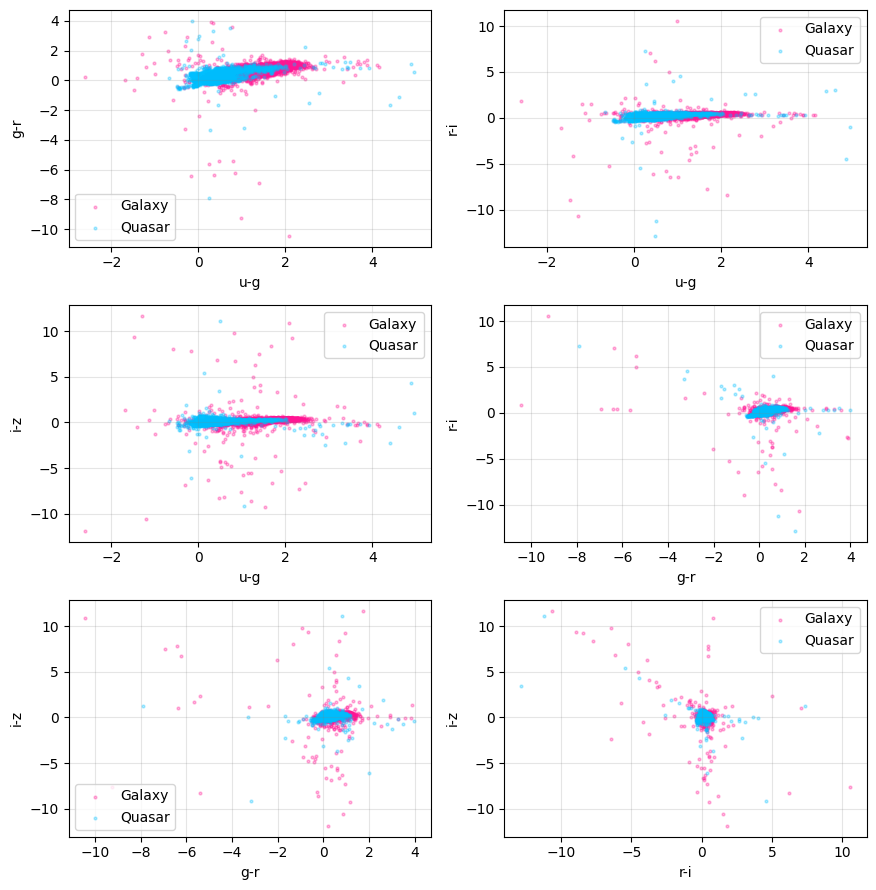

In [6]:
# I could've used corner for the next plots, but the contours were very small and I didn't get a clear idea of the data.

fig, axes = plt.subplots(3, 2, figsize = (9, 9))

axes[0, 0].scatter(u_g[y==0], g_r[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 0].scatter(u_g[y==1], g_r[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 0].grid(c='grey', alpha = 0.2)
axes[0, 0].set_xlabel('u-g')
axes[0, 0].set_ylabel('g-r')
axes[0, 0].legend()

axes[0, 1].scatter(u_g[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 1].scatter(u_g[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 1].grid(c='grey', alpha = 0.2)
axes[0, 1].set_xlabel('u-g')
axes[0, 1].set_ylabel('r-i')
axes[0, 1].legend()


axes[1, 0].scatter(u_g[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 0].scatter(u_g[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 0].grid(c='grey', alpha = 0.2)
axes[1, 0].set_xlabel('u-g')
axes[1, 0].set_ylabel('i-z')
axes[1, 0].legend()

axes[1, 1].scatter(g_r[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 1].scatter(g_r[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 1].grid(c='grey', alpha = 0.2)
axes[1, 1].set_xlabel('g-r')
axes[1, 1].set_ylabel('r-i')
axes[1, 1].legend()

axes[2, 0].scatter(g_r[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 0].scatter(g_r[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 0].grid(c='grey', alpha = 0.2)
axes[2, 0].set_xlabel('g-r')
axes[2, 0].set_ylabel('i-z')
axes[2, 0].legend()

axes[2, 1].scatter(r_i[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 1].scatter(r_i[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 1].grid(c='grey', alpha = 0.2)
axes[2, 1].set_xlabel('r-i')
axes[2, 1].set_ylabel('i-z')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

As noticed before, the plots with $(u-g)$ show a bimodality. This suggests that $(u-g)$ could be the most informative feature.


#### Train-test splitting


In [7]:
X=np.array([u_g, g_r, r_i, i_z]).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=336)


#### Preliminary work: plotting functions


In [106]:
def single_ROC(X_train, X_test, y_train, y_test, classifier, n_components):
    
    # Plots the ROC curves for a classifier trained on the single features
    
    if (classifier == 'gnb'): clf = GaussianNB()
    elif(classifier == 'qda'): clf = QDA()
    elif (classifier == 'gmmb'): clf = GMMBayes(n_components=n_components)
    elif (classifier == 'knn'): clf = KNeighborsClassifier(n_neighbors = n_components)

    colors = ['u-g', 'g-r', 'r-i', 'i-z']

    print('Training the data with a single feature:\n')

    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    for i, col in enumerate(colors):

        clf.fit(X_train[:, i].reshape(-1, 1), y_train)
        y_prob = clf.predict_proba(X_test[:, i].reshape(-1, 1))[:, 1] 
    
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        ax[0].plot(fpr, tpr, label=col)
        ax[1].plot(fpr, tpr, label=col)

    ax[0].set_xlabel('False positive rate')
    ax[0].set_ylabel('True positive rate')
    ax[0].set_title('ROC curve for ' + classifier + ' - single features')
    ax[0].legend(loc='best')
    ax[0].grid(c='grey', alpha = 0.2)

    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title('Zoom')
    ax[1].legend(loc='best')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_ylim(0.7, 1)
    ax[1].set_xlim(0, 0.5)
    
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def progressive_ROC(X_train, X_test, y_train, y_test, classifier, n_components):
    
    # Plots the ROC curves for a classifier trained on a increasing number of features.
    
    if (classifier == 'gnb'): clf = GaussianNB()
    elif(classifier == 'qda'): clf = QDA()
    elif (classifier == 'gmmb'): clf = GMMBayes(n_components=n_components)
    elif (classifier == 'knn'): clf = KNeighborsClassifier(n_neighbors = n_components)

    colors = ['u-g', 'g-r', 'r-i', 'i-z']

    print('Training the data with multiple features:\n')

    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    for i in range(4):

        clf.fit(X_train[:, 0:i+1], y_train)
        y_prob = clf.predict_proba(X_test[:, 0:i+1])[:, 1] 
    
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        ax[0].plot(fpr, tpr, label= '%i features' % (i+1))
        ax[1].plot(fpr, tpr, label= '%i features' % (i+1))

    ax[0].set_xlabel('False positive rate')
    ax[0].set_ylabel('True positive rate')
    ax[0].set_title('ROC curve for ' + classifier + ' - multiple features')
    ax[0].legend(loc='best')
    ax[0].grid(c='grey', alpha = 0.2)

    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title('Zoom')
    ax[1].legend(loc='best')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_ylim(0.9, 1)
    ax[1].set_xlim(0, 0.5)
    
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color):

    # Plots the histograms for the classified data of a given color (u-g, g-r, r-i, i-z)
    # Plots:
    # - The predicted labels for the train dataset;
    # - The true labels for the train dataset;
    # - The predicted labels for the test dataset;
    # - The true labels for the test dataset.
    
    # Defining color
    if (color == 'u-g'): ind = 0
    elif (color == 'g-r'): ind = 1
    elif (color == 'r-i'): ind = 2
    elif (color == 'i-z'): ind = 3

    bins_vec = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]
    bins = bins_vec[ind]
    
    fig, axes = plt.subplots(2, 2, figsize = (12, 8))
    
    axes[0, 0].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 0].hist(X_train[y_train_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 0].hist(X_train[y_train_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 0].grid(c='grey', alpha = 0.2)
    axes[0, 0].set_xlabel(color)
    axes[0, 0].set_title('Predicted labels for train dataset')
    axes[0, 0].legend()
    
    axes[0, 1].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 1].hist(X_train[y_train==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 1].hist(X_train[y_train==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 1].grid(c='grey', alpha = 0.2)
    axes[0, 1].set_xlabel(color)
    axes[0, 1].set_title('True labels for train dataset')
    axes[0, 1].legend()

    axes[1, 0].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 0].hist(X_test[y_test_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 0].hist(X_test[y_test_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 0].grid(c='grey', alpha = 0.2)
    axes[1, 0].set_xlabel(color)
    axes[1, 0].set_title('Predicted labels for test dataset')
    axes[1, 0].legend()
    
    axes[1, 1].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 1].hist(X_test[y_test==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 1].hist(X_test[y_test==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 1].grid(c='grey', alpha = 0.2)
    axes[1, 1].set_xlabel(color)
    axes[1, 1].set_title('True labels for test dataset')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color1, color2):

    # Plots, in a color1 vs color2 plane, the mislabeled points for the train and test data.
    
    # Defining color1
    if (color1 == 'u-g'): ind1 = 0
    elif (color1 == 'g-r'): ind1 = 1
    elif (color1 == 'r-i'): ind1 = 2
    elif (color1 == 'i-z'): ind1 = 3

    # Defining color2
    if (color2 == 'u-g'): ind2 = 0
    elif (color2 == 'g-r'): ind2 = 1
    elif (color2 == 'r-i'): ind2 = 2
    elif (color2 == 'i-z'): ind2 = 3
    
    # "False quasar" = fq: galaxies mislabeled as quasars
    # "False galaxy" = fg: quasars mislabeled as galaxies
    
    mislabels_train = np.where(y_train != y_train_pred)[0]
    fq_train_indexes = mislabels_train[(y_train[mislabels_train] == 0) & (y_train_pred[mislabels_train] == 1)]
    fg_train_indexes = mislabels_train[(y_train[mislabels_train] == 1) & (y_train_pred[mislabels_train] == 0)]
    fq_train = X_train[fq_train_indexes]
    fg_train = X_train[fg_train_indexes]

    mislabels_test = np.where(y_test != y_test_pred)[0]
    fq_test_indexes = mislabels_test[(y_test[mislabels_test] == 0) & (y_test_pred[mislabels_test] == 1)]
    fg_test_indexes = mislabels_test[(y_test[mislabels_test] == 1) & (y_test_pred[mislabels_test] == 0)]
    fq_test = X_test[fq_test_indexes]
    fg_test = X_test[fg_test_indexes]

    
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    ax[0].scatter(X_train[:, ind1], X_train[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[0].scatter(fq_train[:, ind1], fq_train[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[0].scatter(fg_train[:, ind1], fg_train[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[0].grid(c='grey', alpha = 0.2)
    ax[0].set_title('Mislabeled train datapoints')
    ax[0].set_xlabel(color1)
    ax[0].set_ylabel(color2)
    ax[0].legend()
    
    ax[1].scatter(X_test[:, ind1], X_test[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[1].scatter(fq_test[:, ind1], fq_test[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[1].scatter(fg_test[:, ind1], fg_test[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_title('Mislabeled test datapoints')
    ax[1].set_xlabel(color1)
    ax[1].set_ylabel(color2)
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()



## Naive Bayes

We can start the classification with a Naive Bayes classificator. First, we can train the classificator on the single features and see, plotting the ROC curves, what is the most informative one.

Training the data with a single feature:



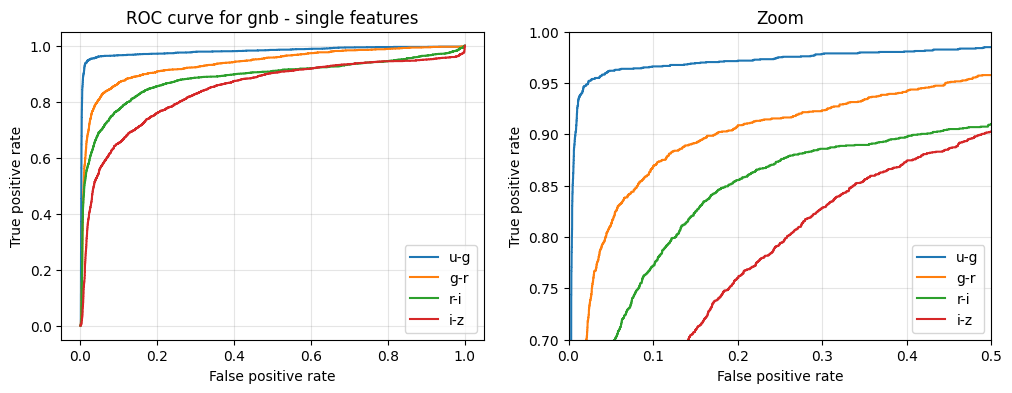

In [107]:
single_ROC(X_train, X_test, y_train, y_test, 'gnb', _)

So, as suspected, the most informative feature is the $(u-g)$ one. Let's plot the ROC curves for the classificator trained on different numbers of features:

Training the data with multiple features:



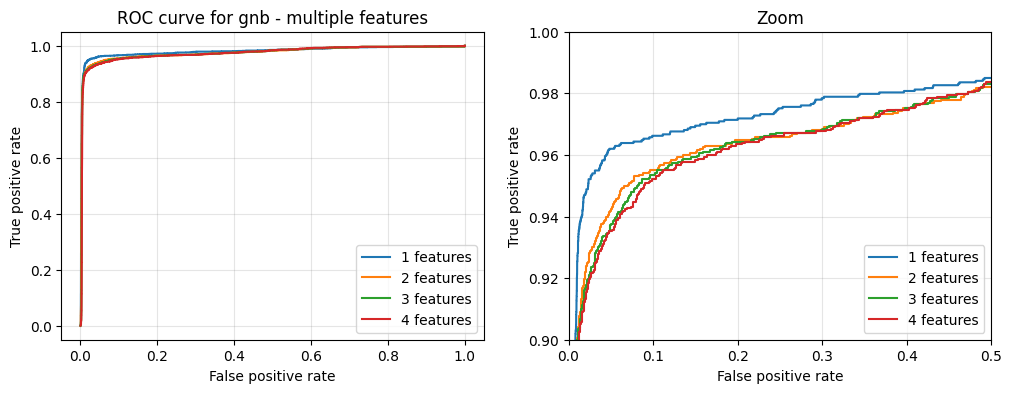

In [108]:
progressive_ROC(X_train, X_test, y_train, y_test, 'gnb', _)

This plot tells us that just the $(u-g)$ feature is enough to classify the dataset. 

We can now plot the results on the data. As a comparison, we'll first use the classifier trained only on the $(u-g)$ feature, and then we'll train it on all the features. We'll plot as an example the classificarion results on the $(u-g)$ feature. 

The following graphs show:

- The predicted labels for the train dataset;
- The true labels for the train dataset;
- The predicted labels for the test dataset;
- The true labels for the test dataset.

#### Training on the $(u-g)$ feature


In [25]:
# TRAINING ON A SINGLE FEATURE
gnb = GaussianNB()
gnb.fit(X_train[:, 0].reshape(-1, 1), y_train)

y_test_pred_gnb = gnb.predict(X_test[:, 0].reshape(-1, 1))
y_train_pred_gnb = gnb.predict(X_train[:, 0].reshape(-1, 1))

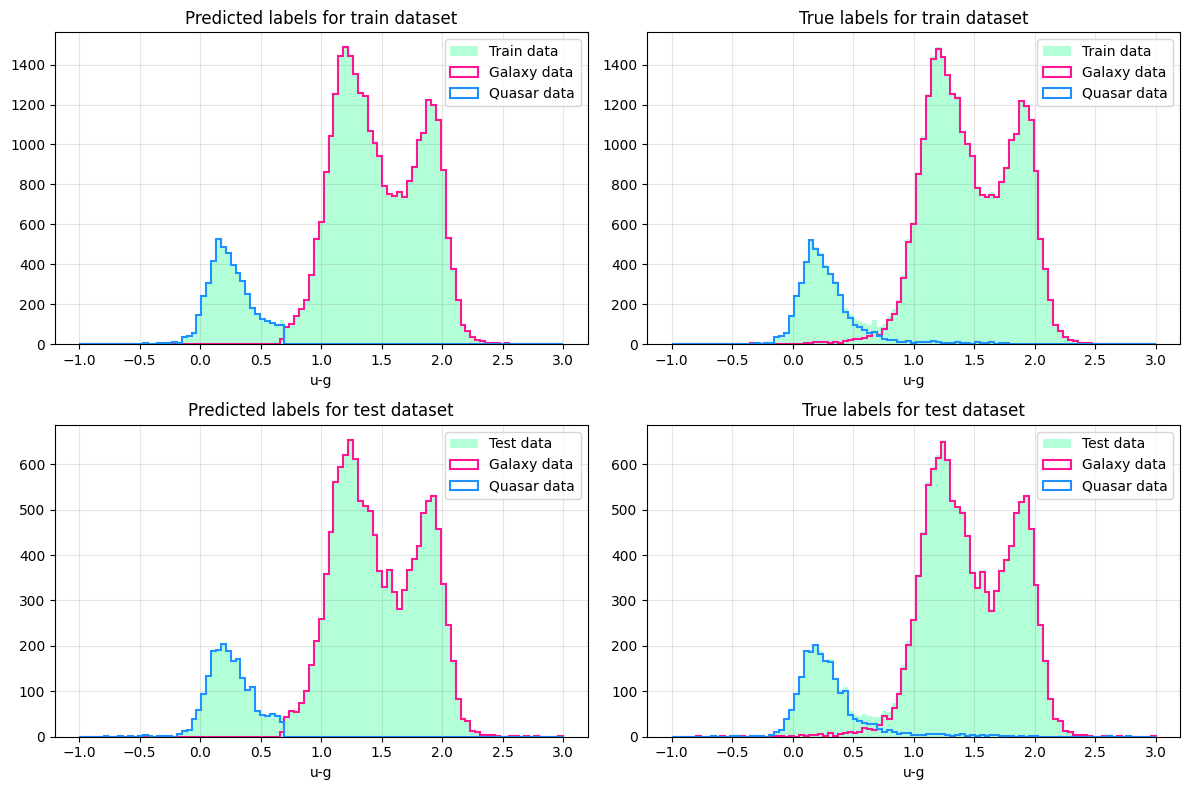

In [38]:
plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_gnb, y_test_pred_gnb, 'u-g')

This shows that also some of the train data are mislabeled. Let's plot the confusion matrix for the train and test data:

In [27]:
print("Accuracy of the prediction on the train data: %.5f" % accuracy_score(y_train, y_train_pred_gnb))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_gnb))

print("\nAccuracy of the prediction on the test data: %.5f" % accuracy_score(y_test, y_test_pred_gnb))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_gnb))

Accuracy of the prediction on the train data: 0.98109
Confusion matrix for the train data:
[[29688   309]
 [  353  4650]]

Accuracy of the prediction on the test data: 0.98060
Confusion matrix for the test data:
[[12738   131]
 [  160  1971]]


We can plot the mismatched datapoints, for example, in the $(u-g) - (g-r)$ plane:

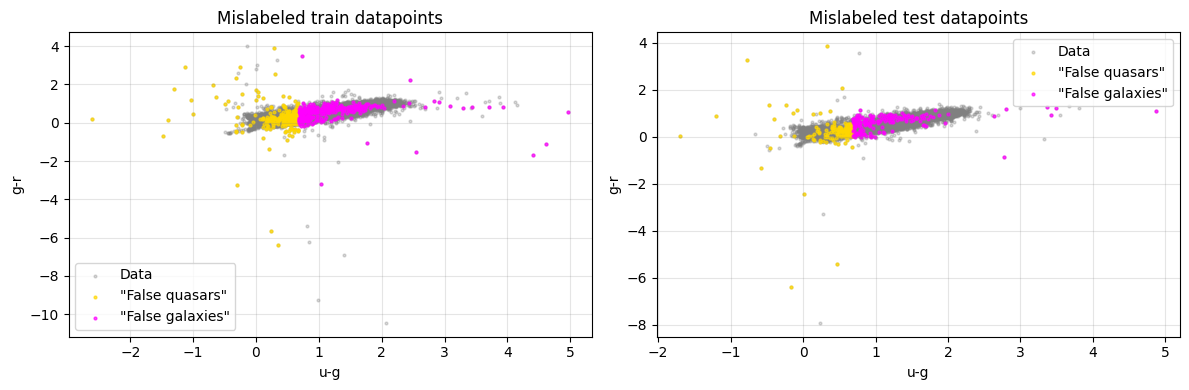

In [28]:
mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_gnb, y_test_pred_gnb, 'u-g', 'g-r')

So, the datapoints in the tails of the two distributions are mislabeled; this is not surprising.

Let's repeat the whole process, this time training the classifier on all the features:

#### Training on all features


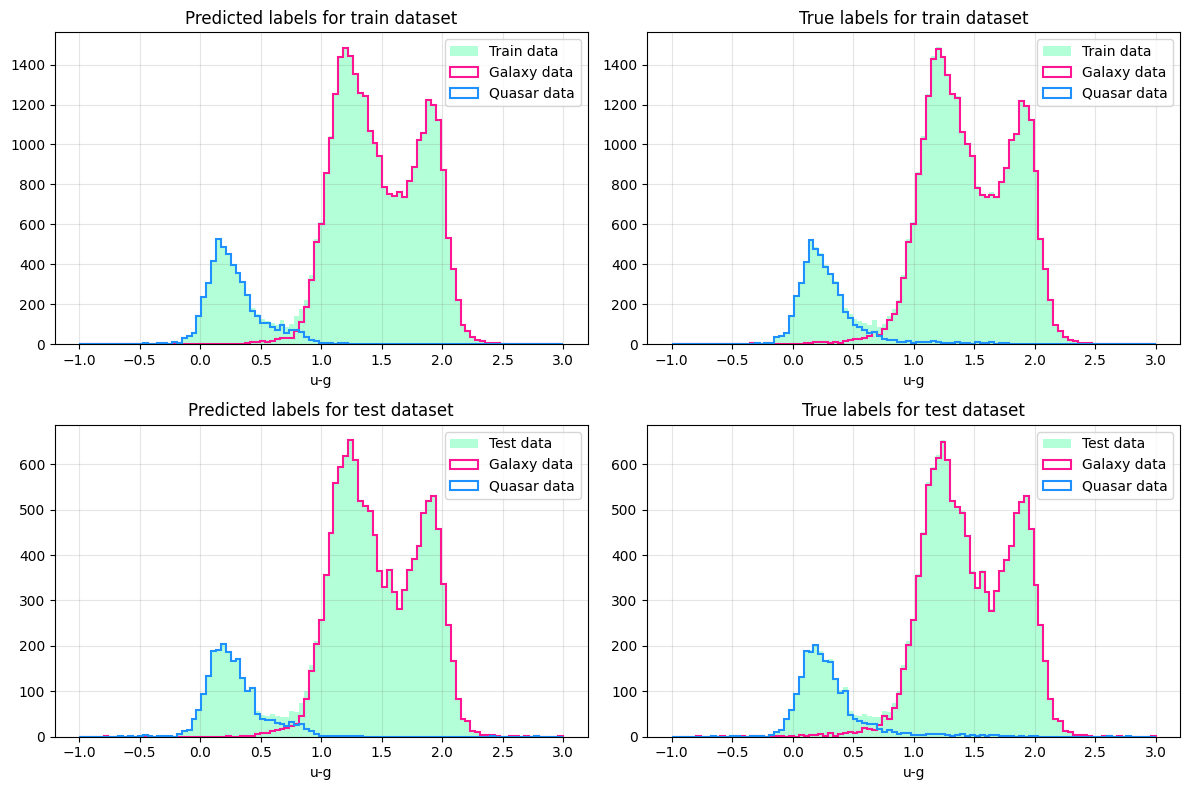

Accuracy of the prediction on the train data: 0.973
Confusion matrix for the train data:
[[29409   588]
 [  369  4634]]

Accuracy of the prediction on the test data: 0.970
Confusion matrix for the test data:
[[12611   258]
 [  185  1946]]


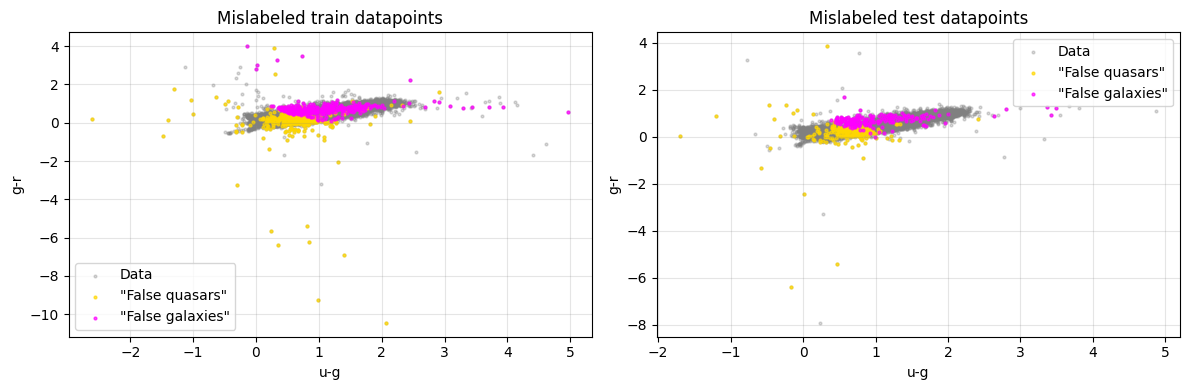

In [37]:
# TRAINING ON ALL THE FEATURES
gnb_tot = GaussianNB()
gnb_tot.fit(X_train, y_train)

y_test_pred_gnb_tot = gnb_tot.predict(X_test)
y_train_pred_gnb_tot = gnb_tot.predict(X_train)

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_gnb_tot, y_test_pred_gnb_tot, 'u-g')

print("Accuracy of the prediction on the train data: %.3f" % accuracy_score(y_train, y_train_pred_gnb_tot))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_gnb_tot))

print("\nAccuracy of the prediction on the test data: %.3f" % accuracy_score(y_test, y_test_pred_gnb_tot))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_gnb_tot))

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_gnb_tot, y_test_pred_gnb_tot, 'u-g', 'g-r')

As predicted by the ROC curves, the classifier trained only on the $(u-g)$ performs better.


## Quadratic Discriminant Analysis

Let's try now using a QDA classification. As before, we'll first plot the ROC curves:

Training the data with a single feature:



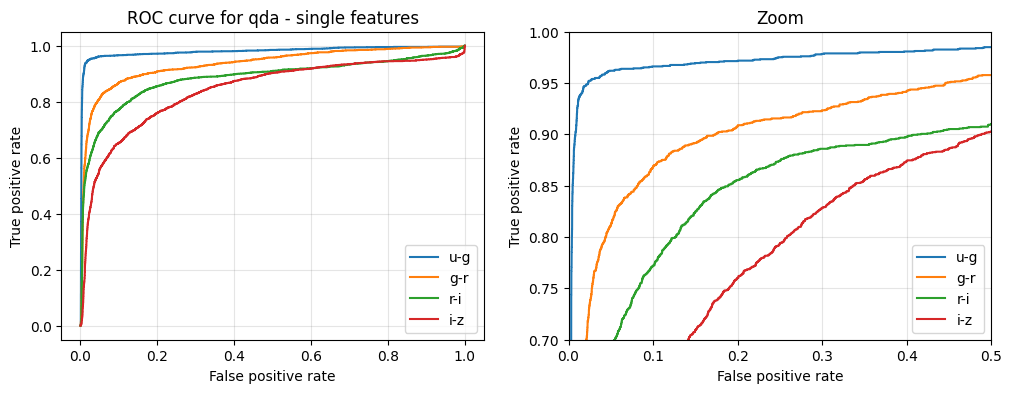

Training the data with multiple features:



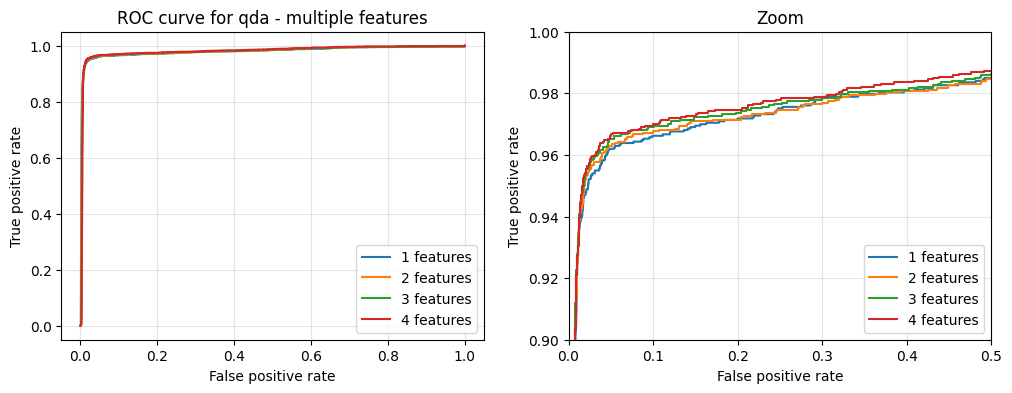

In [109]:
single_ROC(X_train, X_test, y_train, y_test, 'qda', _)
progressive_ROC(X_train, X_test, y_train, y_test, 'qda', _)

The first plots look identical to the ones seen for the Naive Bayes classifier, while the ROC curves for the classifier trained on all the features are different. Let's see the results:

#### Training on the $(u-g)$ feature

Does this classifier yield the same results as the GNB (trained on $(u-g)$) one?

In [31]:
# TRAINING ON THE (u-g) FEATURE
qda = QDA()
qda.fit(X_train[:, 0].reshape(-1, 1), y_train)

y_test_pred_qda = qda.predict(X_test[:, 0].reshape(-1, 1))
y_train_pred_qda = qda.predict(X_train[:, 0].reshape(-1, 1))

print("Accuracy of the prediction on the train data: %.5f" % accuracy_score(y_train, y_train_pred_qda))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_qda))

print("\nAccuracy of the prediction on the test data: %.5f" % accuracy_score(y_test, y_test_pred_qda))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_qda))

Accuracy of the prediction on the train data: 0.98109
Confusion matrix for the train data:
[[29688   309]
 [  353  4650]]

Accuracy of the prediction on the test data: 0.98060
Confusion matrix for the test data:
[[12738   131]
 [  160  1971]]


In [32]:
# Are they exactly the same??
print(np.array_equal(y_test_pred_qda, y_test_pred_gnb))
print(np.array_equal(y_train_pred_qda, y_train_pred_gnb))

True
True


So yes, the QDA classifier yields the same results ar the GNB one, if trained on the single $(u-g)$ feature. Let's see how it performs if trained on all the features:

#### Training on all the features


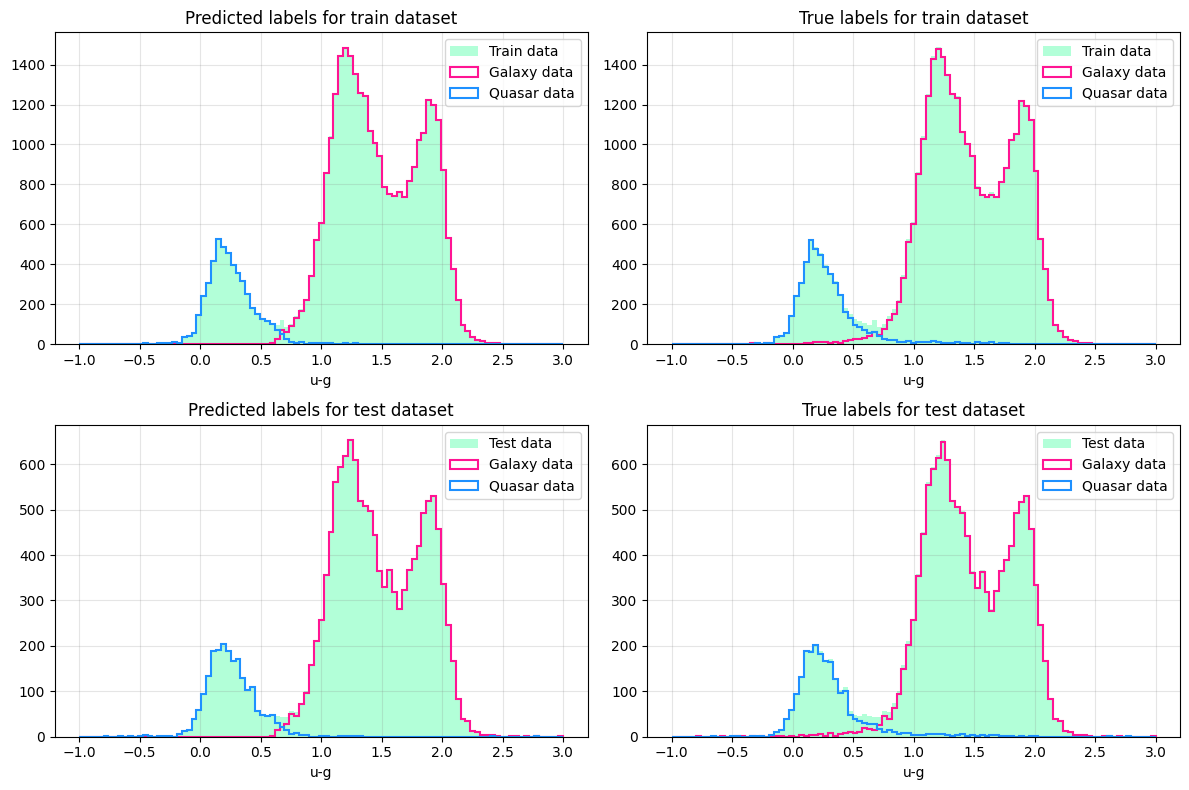

Accuracy of the prediction on the train data: 0.981
Confusion matrix for the train data:
[[29659   338]
 [  343  4660]]

Accuracy of the prediction on the test data: 0.980
Confusion matrix for the test data:
[[12725   144]
 [  149  1982]]


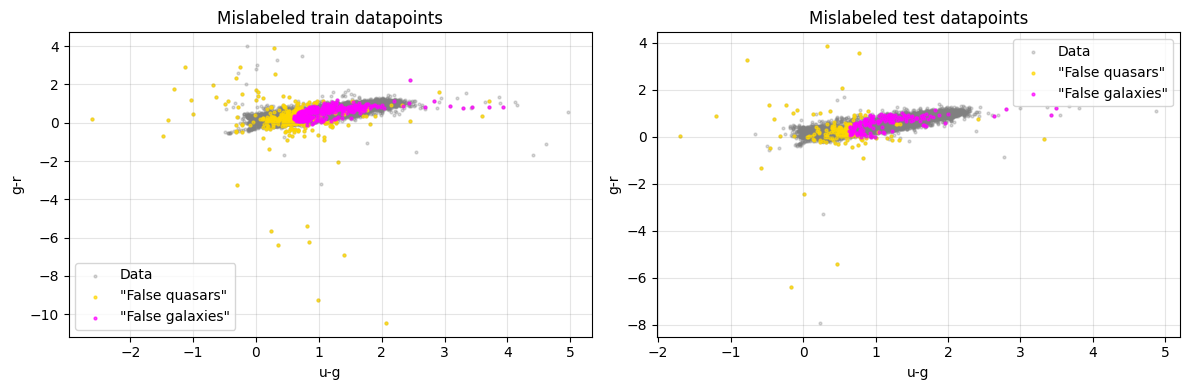

In [36]:
# TRAINING ON ALL THE FEATURES
qda_tot = QDA()
qda_tot.fit(X_train, y_train)

y_test_pred_qda_tot = qda_tot.predict(X_test)
y_train_pred_qda_tot = qda_tot.predict(X_train)

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_qda_tot, y_test_pred_qda_tot, 'u-g')

print("Accuracy of the prediction on the train data: %.3f" % accuracy_score(y_train, y_train_pred_qda_tot))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_qda_tot))

print("\nAccuracy of the prediction on the test data: %.3f" % accuracy_score(y_test, y_test_pred_qda_tot))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_qda_tot))

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_qda_tot, y_test_pred_qda_tot, 'u-g', 'g-r')

In this case, the results are different, and the QDA performed better than the GNB (see end of the code for a summary of the results).

So, if before the best classifier was the gnb one trained only on a single feature, in this case the best one is the one trained on all features.


## GMM Bayes Classifier

With this classifier, we have to decide what are the best number of components and the best number of features to train the classifier on. As a start, we can see how the performance varies for the different features, keeping n_components fixed:

Training the data with a single feature:



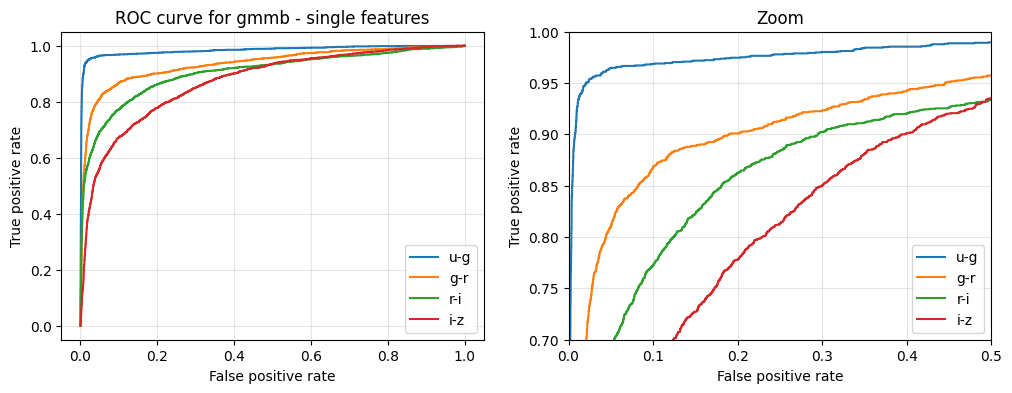

In [110]:
# 10 components
single_ROC(X_train, X_test, y_train, y_test, 'gmmb', 10)

This shows that for the gmmb classifier, too, the $(u-g)$ feature is the most informative one.

Now, we can have an idea of how many features are needed to train the classifier:

Training the data with multiple features:



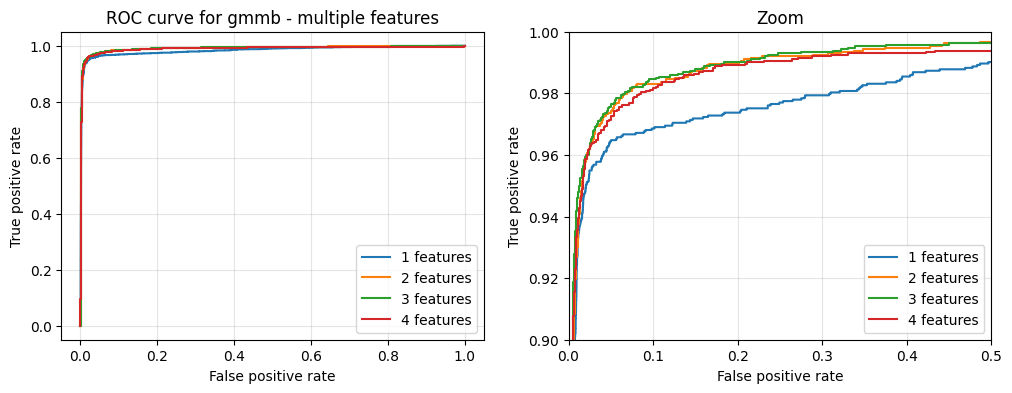

In [111]:
# 10 components
progressive_ROC(X_train, X_test, y_train, y_test, 'gmmb', 10)

So, in this case, we can see that a single feature isn't enough, but training on 2, 3, or 4 features yields very similar results. 

As a last preliminar check, we can see how the performance varies with the number of components (training the classifier on all the features):

Training the data with different numbers of components:



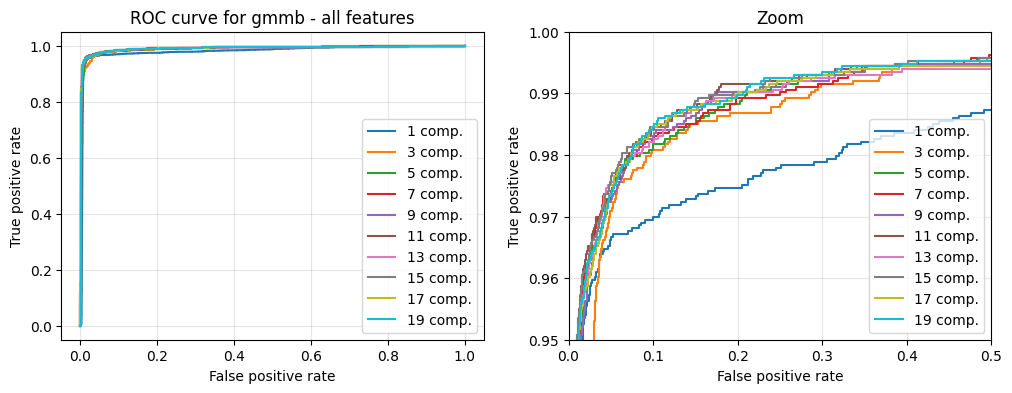

In [113]:
components = np.arange(1, 21, 2, dtype = int)

print('Training the data with different numbers of components:\n')

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

classifier = 'gmmb'

for n in components:
    
    gmmb = GMMBayes(n_components=n)
    gmmb.fit(X_train, y_train)
    y_prob = gmmb.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='%i comp.' % n)
    ax[1].plot(fpr, tpr, label='%i comp.' % n)

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for ' + classifier + ' - all features')
ax[0].legend(loc='best')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='best')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.95, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

This tells us that the classifier trained with a single gaussian gives us the worst results, while increasing the number of gaussians give us more or less the same results.

Now, we can cross-validate. We'll use the AUC as a metric to evaluate the best classifier.

In [137]:
n_splits = 100

n_components = np.arange(1, 21, dtype = int)

AUC_test_matrix = np.empty((len(n_components), 4))
kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, n in enumerate(n_components):     # Cycling on the components -> i
    
    gmmb = GMMBayes(n_components=n)

    for j in range(4):     # Cycling on the number of features -> j
        
        auc_test = np.empty(n_splits)     # I won't keep track of the rms_train this time, there's no plot

        '''
        "for (train_index, test_index) in kf.split(array):
            a_train, a_test = array[train_index], array[test_index]"
            
        Creates a series of indexes for the train and test, cycled like this:
        [1 2 3] [4]
        [1 2 4] [3]
        [1 3 4] [2]
        [2 3 4] [1]
        (This is the case of the leave-one-out cv, but that's the general idea)
        '''
    
        for (train_index, test_index), k in zip(kf.split(X), np.arange(n_splits)):
            X_train_cv, X_test_cv = X[train_index], X[test_index]
            y_train_cv, y_test_cv = y[train_index], y[test_index]
    
            gmmb.fit(X_train_cv[:, 0:j+1], y_train_cv)
            y_prob_cv = gmmb.predict_proba(X_test_cv[:, 0:j+1])[:, 1] 
            
            fpr, tpr, _ = roc_curve(y_test_cv, y_prob_cv)
            auc_test[k] = auc(fpr, tpr)

        AUC_test_matrix[i, j] = np.mean(auc_test)

print(AUC_test_matrix)

[[0.98027873 0.98075147 0.98026378 0.9808906 ]
 [0.98305558 0.98584347 0.98864146 0.9865774 ]
 [0.98293323 0.98766108 0.98904207 0.98969805]
 [0.98300133 0.98843378 0.99015623 0.98931155]
 [0.98285579 0.98994916 0.99044154 0.99047825]
 [0.98348216 0.9905726  0.99117528 0.99078897]
 [0.98369297 0.99077784 0.99091535 0.99105872]
 [0.9843988  0.99084904 0.99149312 0.99129505]
 [0.98393046 0.99068887 0.99128782 0.99156959]
 [0.98415424 0.9905211  0.99153398 0.99141879]
 [0.98438613 0.99069123 0.99125673 0.9915095 ]
 [0.98392302 0.99063079 0.99121321 0.99152503]
 [0.98445771 0.99050208 0.99123924 0.99182021]
 [0.98431229 0.99080964 0.99150742 0.99107813]
 [0.98427596 0.99062567 0.99185283 0.99181616]
 [0.98401557 0.99049081 0.99167657 0.99189116]
 [0.98445104 0.99055712 0.99203198 0.99111037]
 [0.98435024 0.99030328 0.99156837 0.99153081]
 [0.98399623 0.99040509 0.9919413  0.99115161]
 [0.98419152 0.9905282  0.99212052 0.99222587]]


In [174]:
max_index_flat_gmmb = np.argmax(AUC_test_matrix)
    
max_index_2d_gmmb = np.unravel_index(max_index_flat_gmmb, AUC_test_matrix.shape)

n_comp_best_gmmb = n_components[max_index_2d_gmmb[0]]
n_feat_best_gmmb = max_index_2d_gmmb[1]+1

print('Max AUC indexes:')
print(max_index_2d_gmmb)

print('Number of components considered:')
print(n_components)

print('Best number of gaussian components: %i' % n_comp_best_gmmb)
print('Best number of features: %i' % n_feat_best_gmmb)

Max AUC indexes:
(19, 3)
Number of components considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Best number of gaussian components: 20
Best number of features: 4


Let's see the ROC curve associated with this classifier and its results:

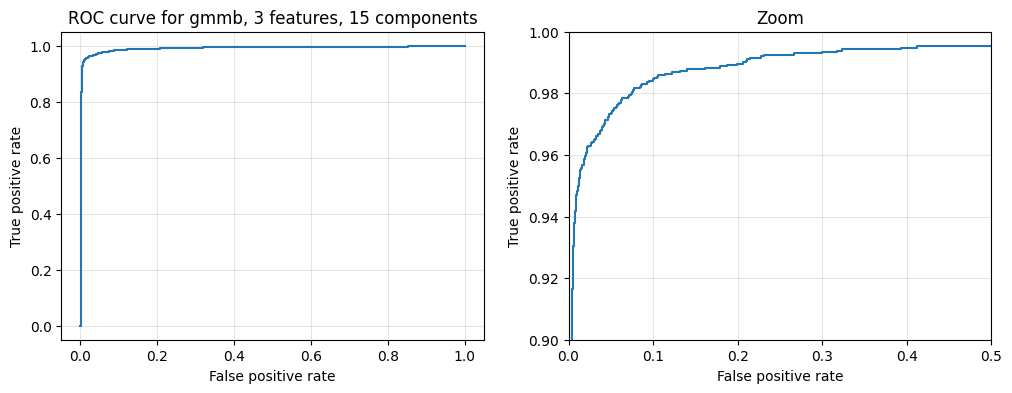

In [122]:
gmmb = GMMBayes(n_components = n_comp_best_gmmb)
gmmb.fit(X_train[:, 0:n_feat_best_gmmb], y_train)

y_prob_gmmb = gmmb.predict_proba(X_test[:, 0:n_feat_best_gmmb])[:, 1] 
fpr_gmmb, tpr_gmmb, _ = roc_curve(y_test, y_prob)

y_test_pred_gmmb = gmmb.predict(X_test[:, 0:n_feat_best_gmmb])
y_train_pred_gmmb = gmmb.predict(X_train[:, 0:n_feat_best_gmmb])

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(fpr_gmmb, tpr_gmmb)
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for gmmb, %i features, %i components' % (n_feat_best_gmmb, n_comp_best_gmmb))
ax[0].grid(c='grey', alpha = 0.2)

ax[1].plot(fpr_gmmb, tpr_gmmb)
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.9, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

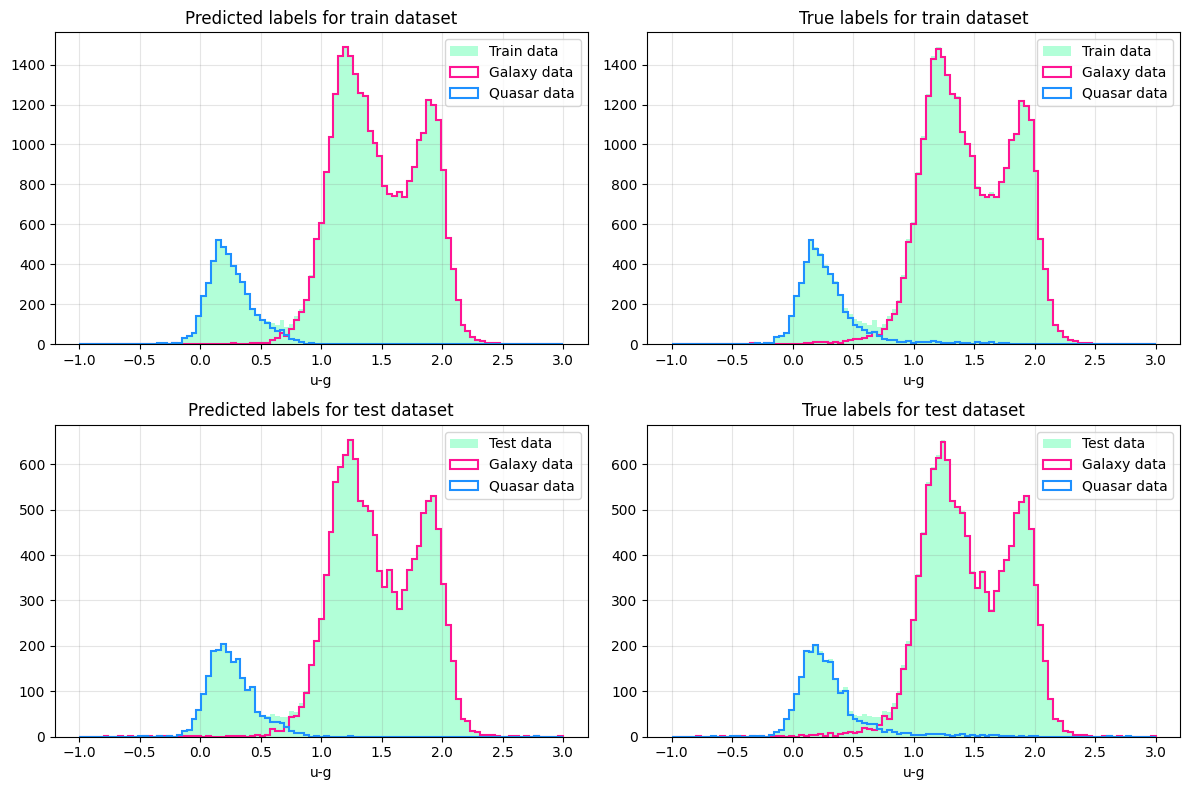

Accuracy of the prediction on the train data: 0.98483
Confusion matrix for the train data:
[[29762   235]
 [  296  4707]]

Accuracy of the prediction on the test data: 0.98433
Confusion matrix for the test data:
[[12766   103]
 [  132  1999]]


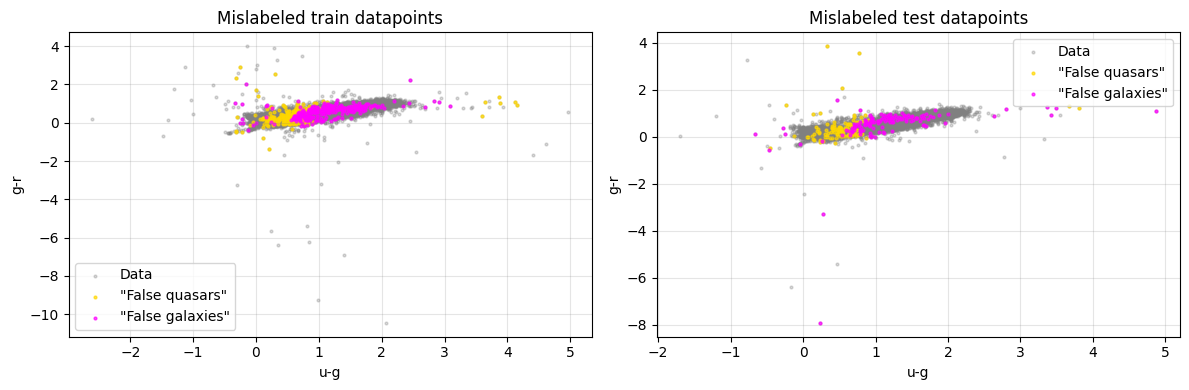

In [123]:
plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_gmmb, y_test_pred_gmmb, 'u-g')

print("Accuracy of the prediction on the train data: %.5f" % accuracy_score(y_train, y_train_pred_gmmb))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_gmmb))

print("\nAccuracy of the prediction on the test data: %.5f" % accuracy_score(y_test, y_test_pred_gmmb))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_gmmb))

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_gmmb, y_test_pred_gmmb, 'u-g', 'g-r')


## K-nearest neighbors classifier


For this classifier, too, we need to decide (with a cross-validation) what is the best number of neighbors to use.

As before, we'll plot the ROC curves to get an idea of how the classifiers behave. First, the classifier with n_neighbors fixed, and varying features:

Training the data with a single feature:



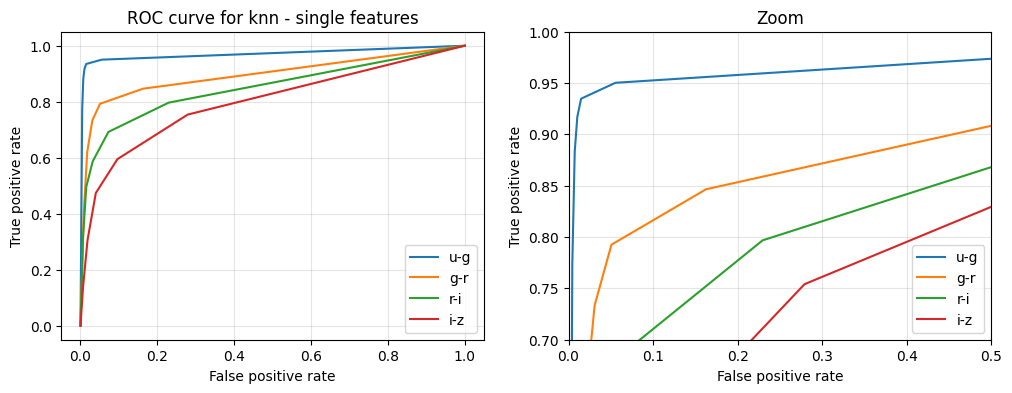

In [114]:
# 5 nearest neighbors
single_ROC(X_train, X_test, y_train, y_test, 'knn', 5)

Then we can plot the ROC curves for n_neighbors fixed, varying how many features we use to train the classifier:

Training the data with multiple features:



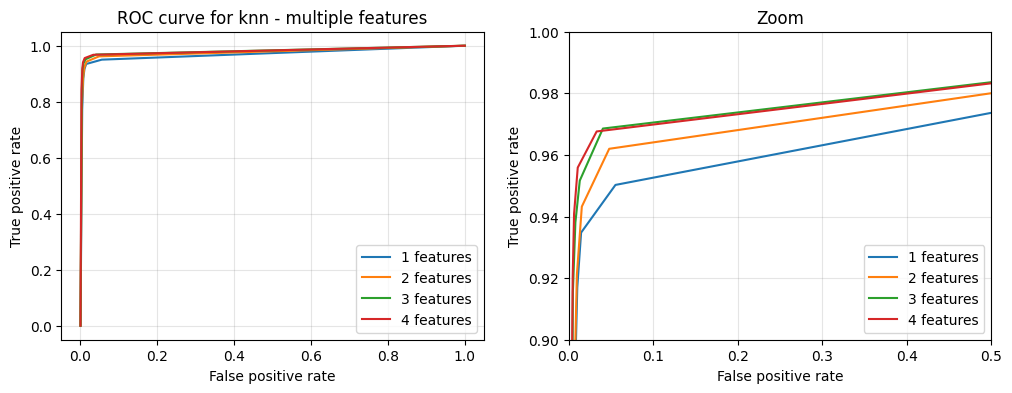

In [115]:
progressive_ROC(X_train, X_test, y_train, y_test, 'knn', 5)

This shows that, as before, training the classifier on a single feature isn't enough. We'll have to cross-validate on this value, too.

Last check to see how the performance varies: changing n_neighbors (and using all features):

Training the data with different numbers of neighbors:



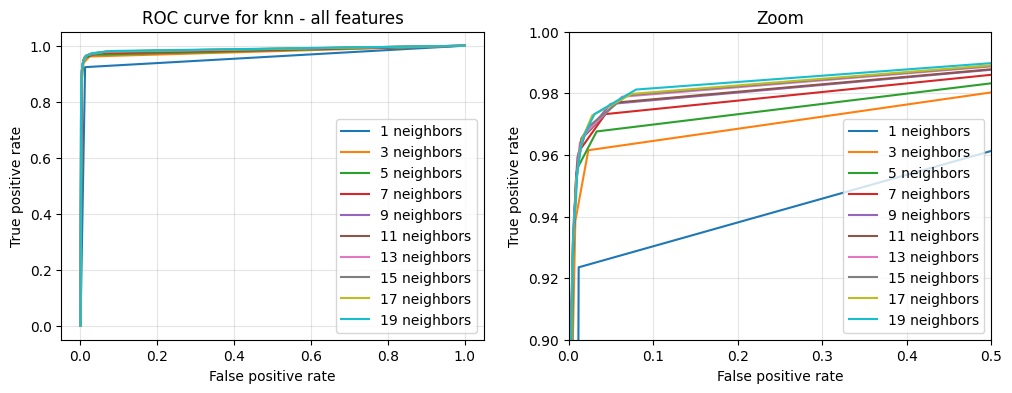

In [164]:
neighbors = np.arange(1, 21, 2, dtype = int)

print('Training the data with different numbers of neighbors:\n')

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

classifier = 'knn'

for n in neighbors:
    
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    y_prob = knn.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='%i neighbors' % n)
    ax[1].plot(fpr, tpr, label='%i neighbors' % n)

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for ' + classifier + ' - all features')
ax[0].legend(loc='best')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='best')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.9, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

So, by this plot, it seems that increasing the number of nearest neighbors yields better results. We can check with cross-validation:

In [135]:
n_splits = 100

n_neighbors = np.arange(1, 21, dtype = int)

AUC_test_matrix_knn = np.empty((len(n_neighbors), 4))
kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, n in enumerate(n_neighbors):     # Cycling on the neighbors -> i
    
    knn = KNeighborsClassifier(n_neighbors = n)

    for j in range(4):     # Cycling on the number of features -> j
        
        auc_test_knn = np.empty(n_splits)     # I won't keep track of the rms_train this time, there's no plot

        for (train_index, test_index), k in zip(kf.split(X), np.arange(n_splits)):
            X_train_cv, X_test_cv = X[train_index], X[test_index]
            y_train_cv, y_test_cv = y[train_index], y[test_index]
    
            knn.fit(X_train_cv[:, 0:j+1], y_train_cv)
            y_prob_cv = knn.predict_proba(X_test_cv[:, 0:j+1])[:, 1] 
            
            fpr, tpr, _ = roc_curve(y_test_cv, y_prob_cv)
            auc_test_knn[k] = auc(fpr, tpr)

        AUC_test_matrix_knn[i, j] = np.mean(auc_test_knn)

print(AUC_test_matrix_knn)

[[0.93695929 0.94192394 0.95189796 0.95897475]
 [0.96185162 0.96616876 0.97068966 0.97380982]
 [0.96775867 0.97214178 0.97563827 0.97768858]
 [0.97097388 0.97486182 0.9781238  0.97994821]
 [0.97233029 0.97653934 0.97966057 0.98130692]
 [0.97298888 0.97787784 0.98092186 0.98219055]
 [0.97377803 0.97875172 0.98164218 0.98287508]
 [0.9741767  0.97924651 0.98239253 0.98403952]
 [0.97471692 0.9800876  0.98269431 0.98460766]
 [0.97504038 0.98028344 0.98318249 0.98506147]
 [0.97522264 0.98120317 0.983534   0.98553245]
 [0.97538064 0.98181964 0.98399651 0.98571146]
 [0.97547838 0.98233136 0.98428538 0.98615992]
 [0.97554448 0.98288658 0.98465537 0.9866189 ]
 [0.97584613 0.98353762 0.98502728 0.98675778]
 [0.97608219 0.98376639 0.98528044 0.98700776]
 [0.97651239 0.98409304 0.98563021 0.98717628]
 [0.97641886 0.98410064 0.98580278 0.9873297 ]
 [0.97654213 0.9841885  0.9859924  0.98744094]
 [0.9766846  0.98434711 0.98610295 0.98770273]]


In [148]:
max_index_flat_knn = np.argmax(AUC_test_matrix_knn)
    
max_index_2d_knn = np.unravel_index(max_index_flat_knn, AUC_test_matrix_knn.shape)

n_comp_best_knn = n_neighbors[max_index_2d_knn[0]]
n_feat_best_knn = max_index_2d_knn[1]+1

print('Max AUC indexes:')
print(max_index_2d_knn)

print('Number of nearest neighbors considered:')
print(n_neighbors)

print('Best number of nearest neighbors: %i' % n_comp_best_knn)
print('Best number of features: %i' % n_feat_best_knn)

Max AUC indexes:
(19, 3)
Number of nearest neighbors considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Best number of nearest neighbors: 20
Best number of features: 4


This cross-validation confirms that the best number of nearest neighbors is 20 (and probably, it would increase by considering a higher number of nearest neighbors), with 4 features to train the classifier. To avoid overfitting, we can check with other metrics: the accuracy (= correct predictions/total number of predictions) and the average precision.

In [143]:
# Accuracy cv

n_splits = 100

n_neighbors = np.arange(1, 21, dtype = int)

accuracy_test_matrix_knn = np.empty((len(n_neighbors), 4))
kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, n in enumerate(n_neighbors):     # Cycling on the neighbors -> i
    
    knn = KNeighborsClassifier(n_neighbors = n)

    for j in range(4):     # Cycling on the number of features -> j
            
        accuracy_test_knn = np.empty(n_splits)     # I won't keep track of the rms_train this time, there's no plot

        for (train_index, test_index), k in zip(kf.split(X), np.arange(n_splits)):
            X_train_cv, X_test_cv = X[train_index], X[test_index]
            y_train_cv, y_test_cv = y[train_index], y[test_index]
    
            knn.fit(X_train_cv[:, 0:j+1], y_train_cv)

            y_pred_test_cv = knn.predict(X_test_cv[:, 0:j+1])

            accuracy_test_knn[k] = accuracy_score(y_test_cv, y_pred_test_cv)

        accuracy_test_matrix_knn[i, j] = np.mean(accuracy_test_knn)

print(accuracy_test_matrix_knn)

[[0.96944 0.97162 0.97664 0.98012]
 [0.97226 0.9752  0.97918 0.98158]
 [0.97894 0.97978 0.98278 0.98494]
 [0.9787  0.98028 0.98386 0.98526]
 [0.98006 0.98112 0.98438 0.98582]
 [0.97982 0.9809  0.9842  0.98584]
 [0.98038 0.98142 0.9843  0.9861 ]
 [0.9804  0.9815  0.98448 0.98582]
 [0.98076 0.98186 0.98444 0.98584]
 [0.98064 0.98188 0.98444 0.98572]
 [0.9809  0.98192 0.98434 0.98598]
 [0.98066 0.98208 0.9844  0.98596]
 [0.98076 0.9824  0.98446 0.98594]
 [0.98056 0.9823  0.9844  0.9857 ]
 [0.98092 0.98242 0.9843  0.9859 ]
 [0.98086 0.98242 0.98454 0.98582]
 [0.98102 0.9824  0.98428 0.986  ]
 [0.98086 0.98262 0.98454 0.98594]
 [0.981   0.98238 0.9843  0.98596]
 [0.98076 0.9823  0.98442 0.98592]]


In [149]:
max_index_flat_knn_acc = np.argmax(accuracy_test_matrix_knn)
    
max_index_2d_knn_acc = np.unravel_index(max_index_flat_knn_acc, accuracy_test_matrix_knn.shape)

n_comp_best_knn_acc = n_neighbors[max_index_2d_knn_acc[0]]
n_feat_best_knn_acc = max_index_2d_knn_acc[1]+1

print('Max accuracy indexes:')
print(max_index_2d_knn_acc)

print('Number of nearest neighbors considered:')
print(n_neighbors)

print('Best number of nearest neighbors: %i' % n_comp_best_knn_acc)
print('Best number of features: %i' % n_feat_best_knn_acc)

Max accuracy indexes:
(6, 3)
Number of nearest neighbors considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Best number of nearest neighbors: 7
Best number of features: 4


In [160]:
# Average precision cv
# Note: I wanted to use AUC-PR, the area under the precision-recall curve, but I couldn't find a built-in function for it. 
# Most examples I found online use instead the average precision, sometimes as if it were the AUC-PR, but the documentation 
# on sklearn specifies that the two quantities are different. From what I understood, it is because the interpolation of the curve
# using the trapezoidal rule (used for the AUC-ROC) is "too optimistic".

n_splits = 100

n_neighbors = np.arange(1, 21, dtype = int)

AP_test_matrix_knn = np.empty((len(n_neighbors), 4))
kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, n in enumerate(n_neighbors):     # Cycling on the neighbors -> i
    
    knn = KNeighborsClassifier(n_neighbors = n)

    for j in range(4):     # Cycling on the number of features -> j
        
        ap_test_knn = np.empty(n_splits)     # I won't keep track of the rms_train this time, there's no plot

        for (train_index, test_index), k in zip(kf.split(X), np.arange(n_splits)):
            X_train_cv, X_test_cv = X[train_index], X[test_index]
            y_train_cv, y_test_cv = y[train_index], y[test_index]
    
            knn.fit(X_train_cv[:, 0:j+1], y_train_cv)
            y_prob_cv = knn.predict_proba(X_test_cv[:, 0:j+1])[:, 1] 

            ap_test_knn[k] = average_precision_score(y_test_cv, y_prob_cv)

        AP_test_matrix_knn[i, j] = np.mean(ap_test_knn)

print(AP_test_matrix_knn)

[[0.8123968  0.82504062 0.85461405 0.8754097 ]
 [0.890232   0.90211242 0.91730387 0.92621686]
 [0.90902578 0.92125274 0.93276489 0.93979548]
 [0.91878326 0.92946041 0.94038546 0.94755294]
 [0.92413066 0.93451933 0.94491236 0.95178784]
 [0.92797074 0.93880873 0.94807596 0.9543905 ]
 [0.93039414 0.94204487 0.95048887 0.95603008]
 [0.9317155  0.94406723 0.95304742 0.9583875 ]
 [0.93296528 0.94614109 0.95393468 0.95996183]
 [0.9341287  0.94740647 0.95537477 0.96101302]
 [0.93500739 0.94968432 0.95648101 0.96210911]
 [0.93618982 0.95112088 0.95757346 0.96274462]
 [0.93659181 0.95224418 0.95800279 0.96350543]
 [0.93748897 0.95361234 0.95855031 0.96422579]
 [0.93819983 0.95472315 0.95912864 0.96478934]
 [0.93865241 0.9552237  0.95979045 0.96518718]
 [0.9393299  0.95625228 0.96089309 0.96542769]
 [0.93997875 0.95632467 0.96119999 0.96618225]
 [0.94025674 0.95657601 0.96159377 0.96638002]
 [0.94102144 0.95689525 0.96183767 0.96690527]]


In [161]:
max_index_flat_knn_ap = np.argmax(AP_test_matrix_knn)
    
max_index_2d_knn_ap = np.unravel_index(max_index_flat_knn_ap, AP_test_matrix_knn.shape)

n_comp_best_knn_ap = n_neighbors[max_index_2d_knn_ap[0]]
n_feat_best_knn_ap = max_index_2d_knn_ap[1]+1

print('Max average precision indexes:')
print(max_index_2d_knn_ap)

print('Number of nearest neighbors considered:')
print(n_neighbors)

print('Best number of nearest neighbors: %i' % n_comp_best_knn_ap)
print('Best number of features: %i' % n_feat_best_knn_ap)

Max average precision indexes:
(19, 3)
Number of nearest neighbors considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Best number of nearest neighbors: 20
Best number of features: 4


So, the average prediction score agrees with the AUC-ROC on the best nearest neighbors number and the best number of features to train the classifier with; the accuracy score, instead, says that the best number of nearest neighbors is 7 and the best number of features is 4. While the accuracy score is more robust for balanced distributions (and this is not the case: there are $\sim43000$ galaxy datapoints vs $\sim7000$ quasar datapoints), I'm afraid that the other metrics could be overfitting.

We can plot their performance:

#### Number of neighbors = 20, number of features = 4


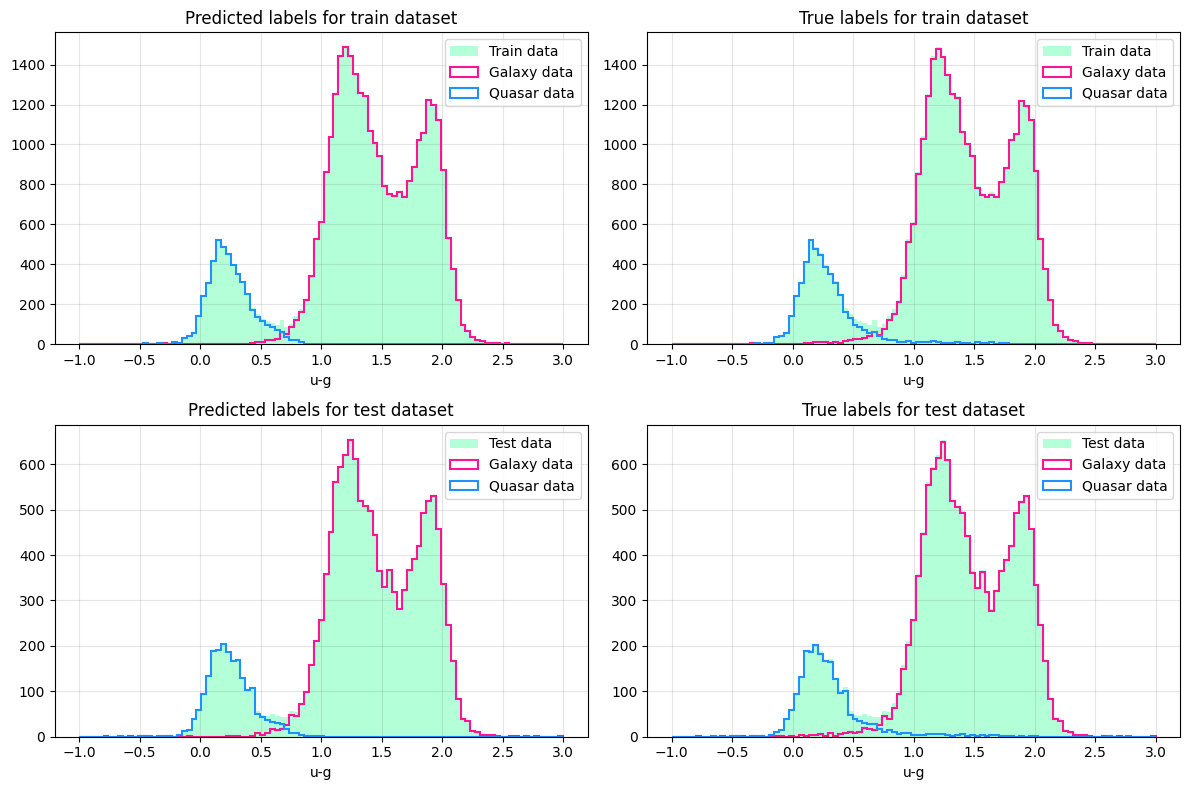

Accuracy of the prediction on the train data: 0.986
Confusion matrix for the train data:
[[29814   183]
 [  304  4699]]

Accuracy of the prediction on the test data: 0.985
Confusion matrix for the test data:
[[12786    83]
 [  136  1995]]


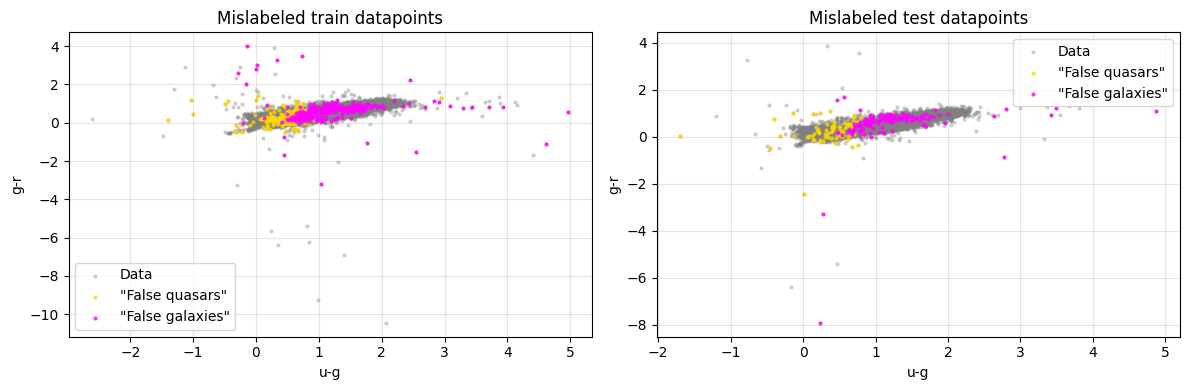

In [156]:
knn_20 = KNeighborsClassifier(n_neighbors = 20)
knn_20.fit(X_train, y_train)

y_test_pred_knn_20 = knn_20.predict(X_test)
y_train_pred_knn_20 = knn_20.predict(X_train)

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_knn_20, y_test_pred_knn_20, 'u-g')

print("Accuracy of the prediction on the train data: %.3f" % accuracy_score(y_train, y_train_pred_knn_20))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_knn_20))

print("\nAccuracy of the prediction on the test data: %.3f" % accuracy_score(y_test, y_test_pred_knn_20))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_knn_20))

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_knn_20, y_test_pred_knn_20, 'u-g', 'g-r')


#### Number of neighbors = 7, number of features = 3


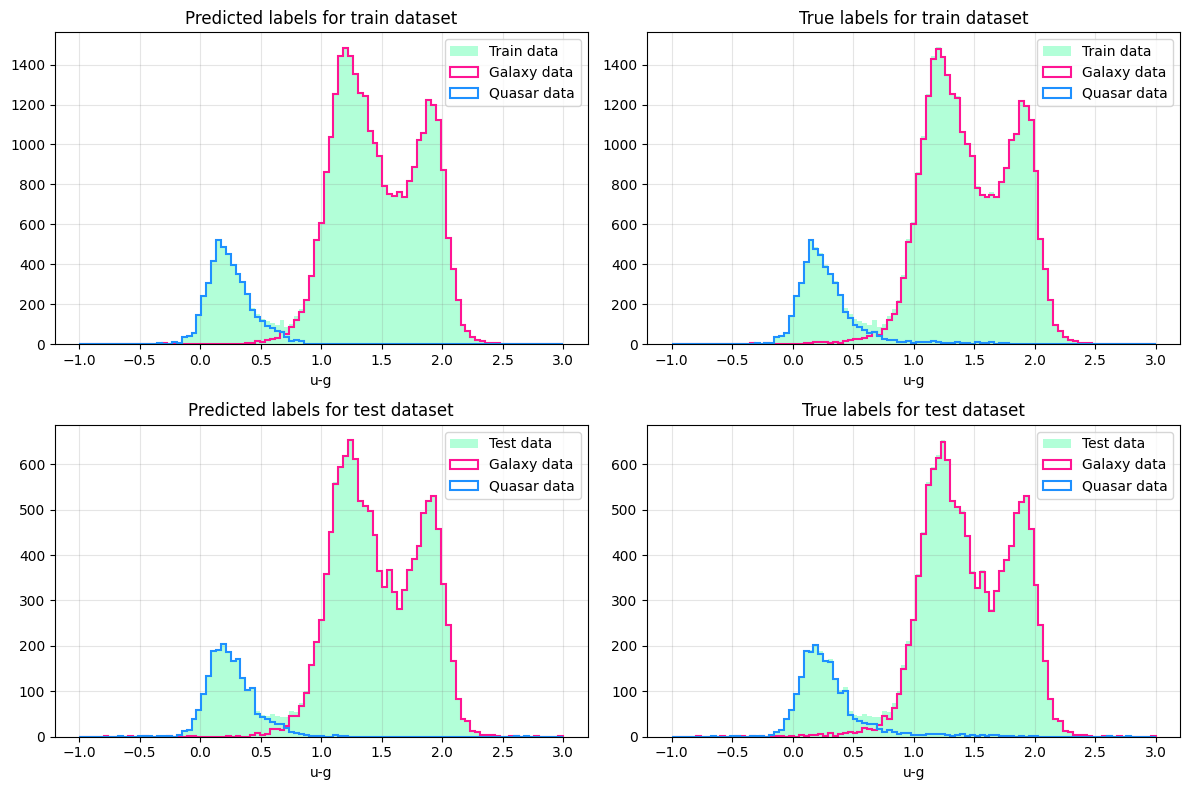

Accuracy of the prediction on the train data: 0.988
Confusion matrix for the train data:
[[29834   163]
 [  271  4732]]

Accuracy of the prediction on the test data: 0.985
Confusion matrix for the test data:
[[12776    93]
 [  128  2003]]


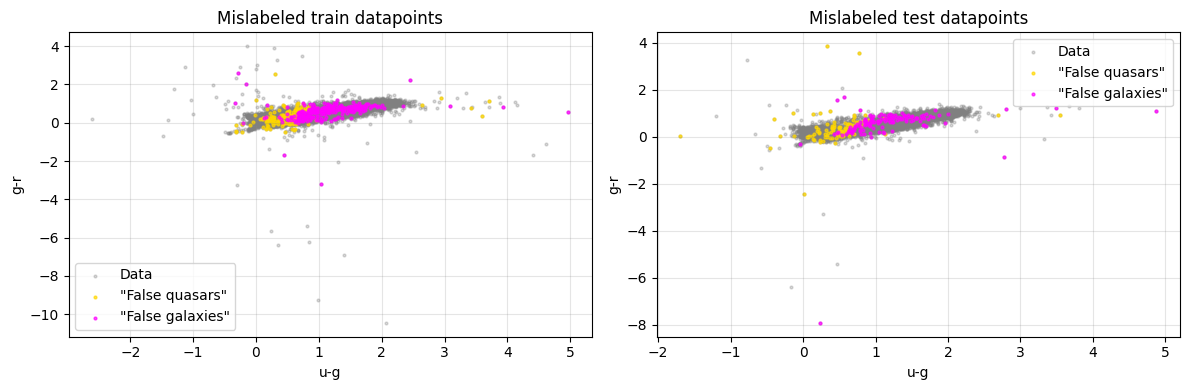

In [162]:
knn_7 = KNeighborsClassifier(n_neighbors = 7)
knn_7.fit(X_train, y_train)

y_test_pred_knn_7 = knn_7.predict(X_test)
y_train_pred_knn_7 = knn_7.predict(X_train)

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_knn_7, y_test_pred_knn_7, 'u-g')

print("Accuracy of the prediction on the train data: %.3f" % accuracy_score(y_train, y_train_pred_knn_7))
print("Confusion matrix for the train data:")
print(confusion_matrix(y_train, y_train_pred_knn_7))

print("\nAccuracy of the prediction on the test data: %.3f" % accuracy_score(y_test, y_test_pred_knn_7))
print("Confusion matrix for the test data:")
print(confusion_matrix(y_test, y_test_pred_knn_7))

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_knn_7, y_test_pred_knn_7, 'u-g', 'g-r')

These results show that, even if the model is overfitting, it is still doing a great job on the test data.


## Results

Here we'll repeat the results to better compare one classifier to another.

First, the confusion matrices:

In [173]:
def confusion_table(y_true, y_pred):

    m = confusion_matrix(y_true, y_pred)
    true_gal = m[0, 0]     # Galaxies labeled as galaxies
    false_qua = m[0, 1]     # Galaxies labeled as quasars
    false_gal = m[1, 0]     # Quasars labeled as galaxies
    true_qua = m[1, 1]     # Quasars labeled as quasars

    return true_gal, false_qua, false_gal, true_qua

In [184]:
classifiers = ['Naive Bayes', 'QDA', 'GMM Bayes', 'K-nearest neighbors', 'K-nearest neighbors']
notes = ['Single feature', 'All features', 'INSERISCI VALORE CV', 'INSERISCI VALORE CV', 'INSERISCI VALORE CV']

y_train_pred_list = [y_train_pred_gnb, y_train_pred_qda_tot, y_train_pred_gmmb, y_train_pred_knn_20, y_train_pred_knn_7]
y_test_pred_list = [y_test_pred_gnb, y_test_pred_qda_tot, y_test_pred_gmmb, y_test_pred_knn_20, y_test_pred_knn_7]

results_train = []
results_test = []

for (i, classifier), note in zip(enumerate(classifiers), notes):
    true_gal_train, false_qua_train, false_gal_train, true_qua_train = confusion_table(y_train, y_train_pred_list[i])
    true_gal_test, false_qua_test, false_gal_test, true_qua_test = confusion_table(y_test, y_test_pred_list[i])
    
    results_train.append([classifier, note, true_gal_train, false_qua_train, false_gal_train, true_qua_train])
    results_test.append([classifier, note, true_gal_test, false_qua_test, false_gal_test, true_qua_test])
    
train_table = pd.DataFrame(results_train, columns=['Classifier', 'Note', 'True Galaxies', 'False Quasars', 'False Galaxies', 'True Quasars'])
test_table = pd.DataFrame(results_test, columns=['Classifier', 'Note', 'True Galaxies', 'False Quasars', 'False Galaxies', 'True Quasars'])

display(Markdown("### Results of classification on train dataset:"))
display(train_table)

display(Markdown("### Results of classification on test dataset:"))
display(test_table)

### Results of classification on train dataset:

,Classifier,Note,True Galaxies,False Quasars,False Galaxies,True Quasars
0,Naive Bayes,Single feature,29688,309,353,4650
1,QDA,All features,29659,338,343,4660
2,GMM Bayes,INSERISCI VALORE CV,29762,235,296,4707
3,K-nearest neighbors,INSERISCI VALORE CV,29814,183,304,4699
4,K-nearest neighbors,INSERISCI VALORE CV,29834,163,271,4732


### Results of classification on test dataset:

,Classifier,Note,True Galaxies,False Quasars,False Galaxies,True Quasars
0,Naive Bayes,Single feature,12738,131,160,1971
1,QDA,All features,12725,144,149,1982
2,GMM Bayes,INSERISCI VALORE CV,12766,103,132,1999
3,K-nearest neighbors,INSERISCI VALORE CV,12786,83,136,1995
4,K-nearest neighbors,INSERISCI VALORE CV,12776,93,128,2003



Then, some metrics:


In [199]:
def metrics_table(y_true, y_pred):

    acc = accuracy_score(y_true, y_pred)
    compl, contam = completeness_contamination(y_true, y_pred)
    compl=float(compl)
    contam=float(contam)

    # False positive rate = FP / (TN + FP)
    # In this case, FP = Galaxies labeled as quasars, and TN = galaxies labeled as galaxies

    m = confusion_matrix(y_true, y_pred)
    FP = m[0, 1]
    TN = m[0, 0]
    FPR = FP / (TN + FP)

    return acc, compl, contam, FPR

In [200]:
metrics_train = []
metrics_test = []

for (i, classifier), note in zip(enumerate(classifiers), notes):
    acc_train, compl_train, contam_train, FPR_train = metrics_table(y_train, y_train_pred_list[i])
    acc_test, compl_test, contam_test, FPR_test = metrics_table(y_test, y_test_pred_list[i])
    
    metrics_train.append([classifier, note, acc_train, compl_train, contam_train, FPR_train])
    metrics_test.append([classifier, note, acc_test, compl_test, contam_test, FPR_test])
    
train_table_metrics = pd.DataFrame(metrics_train, columns=['Classifier', 'Note', 'Accuracy', 'Completeness', 'Contamination', 'False positive rate'])
test_table_metrics = pd.DataFrame(metrics_test, columns=['Classifier', 'Note', 'Accuracy', 'Completeness', 'Contamination', 'False positive rate'])

train_table_metrics[['Accuracy', 'Completeness', 'Contamination', 'False positive rate']] = train_table_metrics[['Accuracy', 'Completeness', 'Contamination', 'False positive rate']].round(3)
test_table_metrics[['Accuracy', 'Completeness', 'Contamination', 'False positive rate']] = test_table_metrics[['Accuracy', 'Completeness', 'Contamination', 'False positive rate']].round(3)

display(Markdown("### Results of classification on train dataset:"))
display(train_table_metrics)

display(Markdown("### Results of classification on test dataset:"))
display(test_table_metrics)

### Results of classification on train dataset:

,Classifier,Note,Accuracy,Completeness,Contamination,False positive rate
0,Naive Bayes,Single feature,0.981,0.938,0.071,0.010
1,QDA,All features,0.981,0.932,0.069,0.011
2,GMM Bayes,INSERISCI VALORE CV,0.985,0.952,0.059,0.008
3,K-nearest neighbors,INSERISCI VALORE CV,0.986,0.963,0.061,0.006
4,K-nearest neighbors,INSERISCI VALORE CV,0.988,0.967,0.054,0.005


### Results of classification on test dataset:

,Classifier,Note,Accuracy,Completeness,Contamination,False positive rate
0,Naive Bayes,Single feature,0.981,0.938,0.075,0.010
1,QDA,All features,0.980,0.932,0.070,0.011
2,GMM Bayes,INSERISCI VALORE CV,0.984,0.951,0.062,0.008
3,K-nearest neighbors,INSERISCI VALORE CV,0.985,0.960,0.064,0.006
4,K-nearest neighbors,INSERISCI VALORE CV,0.985,0.956,0.060,0.007


In [ ]:
# FAI RANDOM FOREST
# FAI ALTRO???
# FAI SUMMARY
# Una tabella per le confusion matrix, una per le metrics
# MOSTRA IL CLASSIFIER MIGLIORE
# FAI ANDARE UN'ULTIMA VOLTA LE CROSS VALIDATION E GUARDA CHE I RISULTATI SIANO COERENTI CON CIò CHE HAI SCRITTO

In [ ]:
# COSA SIGNIFICA LA STORIA DELLA NAIVE ASSUMPTION NELLE RICHIESTE????
# PERCHE' QDA E GNB DANNO LO STESSO RISULTATO PER IL CLASSIFIER TRAINED SU UNA SOLA FEATURE?